# 1. Predicting treatment effects

In [1]:
pip uninstall recon -y

Found existing installation: recon 0.1.0
Uninstalling recon-0.1.0:
  Successfully uninstalled recon-0.1.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install ./ReCoN[grn]

ERROR: Invalid requirement: './ReCoN[grn]': Expected package name at the start of dependency specifier
    ./ReCoN[grn]
    ^
Hint: It looks like a path. File './ReCoN[grn]' does not exist.
Note: you may need to restart the kernel to use updated packages.


In [3]:
from recon.data.load_data import load_receptor_genes

In [4]:
import numpy as np
import scanpy as sc  # single cell data
import pandas as pd  # data manipulation
import liana as li  # cell communication
import recon  # multilayer and perturbation prediction
import recon.data

In [5]:
human_receptor_grn = recon.data.load_receptor_genes("human_receptor_gene_from_NichenetPKN")

### Loading data

The data for this tutorial can be downloaded together at _____.

In [6]:
rna = sc.read_h5ad("ReCoN/data/perturbation_tuto/rna.h5ad")

Let's check what cell types are present in this dataset

In [ ]:
rna.obs["celltype"].unique().tolist()

['B_cell',
 'ILC',
 'Macrophage',
 'MigDC',
 'Monocyte',
 'NK_cell',
 'Neutrophil',
 'T_cell_CD4',
 'T_cell_CD8',
 'T_cell_gd',
 'Treg',
 'cDC1',
 'cDC2',
 'eTAC',
 'pDC']

### Importing GRNs

You can either generate GRNs direclty with ReCoN or import a previously generated one.<br>
If you wish to generate it directly, please follow the turorial [________]_______.

In [7]:
grn_path = "ReCoN/data/perturbation_tuto/grn.csv"
grn = pd.read_csv(grn_path, index_col=0)
grn = grn.sort_values(by="weight", ascending=False)[:500_000]
grn["source"] = grn["source"].str.capitalize()
grn["target"] = grn["target"].str.capitalize()
grn.head(3)

,source,target,weight
0,Pax5,Mbd1,0.000095
2,Pax5,Smad5,0.000092
1,Pax5,Smad1,0.000092


### Computing cell communication

In [15]:
li.method.cellphonedb(rna, 
            # NOTE by default the resource uses HUMAN gene symbols
            resource_name="mouseconsensus",
            expr_prop=0.00,
            use_raw=False,
            groupby="celltype",
            verbose=True, key_added='cpdb_res')


2025-09-27 16:17:42,095 - INFO - Using resource `mouseconsensus`.
2025-09-27 16:17:42,141 - INFO - Using `.X`!
2025-09-27 16:17:42,157 - WARNING - 15364 features of mat are empty, they will be removed.
2025-09-27 16:17:42,182 - WARNING - Make sure that normalized counts are passed!
2025-09-27 16:17:42,665 - INFO - 0.36 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 1296 samples and 937 features


100%|██████████| 1000/1000 [00:04<00:00, 234.10it/s]


In [16]:
ccc_network = rna.uns["cpdb_res"].copy()
ccc_network = ccc_network[["ligand", "receptor", "lr_means", "source", "target"]]
ccc_network = ccc_network.rename(columns={
    "lr_means": "weight",
    "source": "celltype_source",
    "target": "celltype_target",
    "ligand": "source",
    "receptor": "target"
})
ccc_network = ccc_network[ccc_network['weight'] != 0]

In [17]:
ccc_network.head()

,source,target,weight,celltype_source,celltype_target
406685,App,Cd74,102.485008,cDC2,cDC1
405645,Copa,Cd74,102.370003,cDC1,cDC1
410237,Copa,Cd74,102.366211,eTAC,cDC1
388291,App,Cd74,102.286766,Monocyte,cDC1
387251,Copa,Cd74,102.265007,MigDC,cDC1


### Add receptor & receptor - target genes informations

In [18]:
receptor_genes = recon.data.load_receptor_genes("mouse_receptor_gene_from_NichenetPKN")

genes = np.unique(grn['source'].tolist() + grn['target'].tolist())
receptor_genes = receptor_genes[receptor_genes['target'].isin(genes)]
receptor_genes.head()

,source,target,weight
2,A1bg,Abca1,0.005156
3,A1bg,Abcb1a,0.005877
4,A1bg,Abcb1b,0.005877
7,A1bg,Acsl1,0.005915
8,A1bg,Adk,0.005092


### Choose a molecule to perturb

For this example, we can choose a ligand binding a receptor whose expression varies a lot between cell types. We can start by ranking receptor accodring to their variance in-between groups.

In [19]:
# variance
ccc_network.groupby("target")["weight"].var().sort_values(ascending=False).head(3)

target
Cd74     932.779297
Cd68     155.465271
Itgal    152.500290
Name: weight, dtype: float32

Now, we can start from this receptor if we have a designed molecule already, or choose one of its natural ligands. </br> Here, let's identify the ligands of this ligand in our ccc_network.

In [20]:
ligands = ccc_network[ccc_network["target"]=="Cd74"]['source'].unique().tolist()
ligands

['App', 'Copa']

Seeds are provided as a dictionary with weights per seed.
Creating a multixrank object with seeds as a dictionary.
Identifying produced ligands in response to the perturbation.
Seeds are provided as a dictionary with weights per seed.
Creating a multixrank object with seeds as a dictionary.
Identifying produced ligands in response to the perturbation.
Seeds are provided as a dictionary with weights per seed.
Creating a multixrank object with seeds as a dictionary.
Identifying produced ligands in response to the perturbation.
Seeds are provided as a dictionary with weights per seed.
Creating a multixrank object with seeds as a dictionary.
Identifying produced ligands in response to the perturbation.
Seeds are provided as a dictionary with weights per seed.
Creating a multixrank object with seeds as a dictionary.
Identifying produced ligands in response to the perturbation.
Seeds are provided as a dictionary with weights per seed.
Creating a multixrank object with seeds as a dictionary.


In [21]:
ccc_network[ccc_network["target"]=="Cd74"]

,source,target,weight,celltype_source,celltype_target
406685,App,Cd74,102.485008,cDC2,cDC1
405645,Copa,Cd74,102.370003,cDC1,cDC1
410237,Copa,Cd74,102.366211,eTAC,cDC1
388291,App,Cd74,102.286766,Monocyte,cDC1
387251,Copa,Cd74,102.265007,MigDC,cDC1
...,...,...,...,...,...
252752,App,Cd74,0.200000,NK_cell,T_cell_CD4
256310,Copa,Cd74,0.196667,Neutrophil,T_cell_CD4
259653,App,Cd74,0.195000,T_cell_CD8,T_cell_CD4
261956,App,Cd74,0.195000,T_cell_gd,T_cell_CD4


### Assembling the multilayer

In [22]:
%%time
direct_effect, indirect_effect = recon.explore.multicell_targets(
        seeds=["Copa"],
        celltypes=["B_cell", "pDC", "Macrophage", "NK_cell", "T_cell_CD4", "T_cell_CD8"],
        grn=grn,
        receptor_grn=receptor_genes,
        ccc=ccc_network,
        grn_graph_weighted=True,
        receptor_grn_graph_weighted=True,
        receptor_graph_weighted=False,
        cell_communication_graph_weighted=True,
        cell_communication_graph_directed=False,
        restart_proba=0.6,
        extend_seeds=True,
        njobs=15
    )

Processing celltype 1/6: B_cell
Processing celltype 2/6: pDC
Processing celltype 3/6: Macrophage
Processing celltype 4/6: NK_cell
Processing celltype 5/6: T_cell_CD4
Processing celltype 6/6: T_cell_CD8
Computing intracellular contributions and direct effect...
Computing intercellular contributions and indirect effect...


100%|██████████| 6/6 [00:00<00:00, 34.13it/s]
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:  1.1min remaining:  2.2min
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=6)]: Done   4 out of   6 | elapsed:  1.2min remaining:   34.8s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  1.2min finished


CPU times: user 1min 1s, sys: 6.03 s, total: 1min 7s
Wall time: 2min 9s


### Inferring molecular perturbation

In [23]:
direct_effect.head()

celltype_target,B_cell,pDC,Macrophage,NK_cell,T_cell_CD4,T_cell_CD8
gene,,,,,,
Zzz3,5.568139e-09,9.124538e-09,6.006453e-09,1.443905e-09,1.465908e-09,1.560960e-09
Zzef1,7.910818e-09,1.276460e-08,8.532004e-09,2.241151e-09,2.276372e-09,2.427962e-09
Zyx,2.311808e-08,2.538018e-08,2.369134e-08,2.052888e-08,2.055242e-08,2.059275e-08
Zyg11b,1.309827e-09,2.150962e-09,1.419632e-09,3.216471e-10,3.280418e-10,3.516321e-10
Zxdc,1.692286e-09,2.749142e-09,1.834584e-09,4.614275e-10,4.729096e-10,5.125789e-10


In [24]:
indirect_effect.head()

celltype_target        B_cell                                            \
celltype_source        B_cell           pDC    Macrophage       NK_cell   
gene                                                                      
Zzz3             7.183332e-14  7.913036e-14  6.293259e-14  1.600594e-14   
Zzef1            9.008843e-14  2.208307e-14  3.041107e-14  8.307700e-15   
Zyx              2.161545e-13  3.788882e-14  4.465807e-14  1.414912e-14   
Zyg11b           1.069608e-14  7.478946e-15  8.779712e-15  3.251270e-15   
Zxdc             1.056516e-14  4.435250e-15  4.676752e-15  1.387966e-15   

celltype_target                                       pDC                \
celltype_source    T_cell_CD4    T_cell_CD8        B_cell           pDC   
gene                                                                      
Zzz3             1.595044e-14  1.519382e-14  7.496581e-14  1.893066e-13   
Zzef1            7.715768e-15  8.066270e-15  2.826861e-14  1.525393e-13   
Zyx              1.346540e-14  1.256323e-14  7.395198e-14  3.831654e-13   
Zyg11b           2.754708e-15  3.001793e-15  7.173546e-15  2.332657e-14   
Zxdc             1.255725e-15  1.337621e-15  5.696248e-15  3.359916e-14   

celltype_target                              ...    T_cell_CD4                \
celltype_source    Macrophage       NK_cell  ...    Macrophage       NK_cell   
gene                                         ...                               
Zzz3             1.035491e-13  3.099726e-14  ...  7.260443e-14  2.013464e-14   
Zzef1            5.631959e-14  1.769248e-14  ...  2.853657e-14  8.541661e-15   
Zyx              1.089892e-13  3.809506e-14  ...  3.354725e-14  1.072773e-14   
Zyg11b           1.535287e-14  5.387020e-15  ...  8.192193e-15  2.671231e-15   
Zxdc             9.892045e-15  3.383646e-15  ...  5.041097e-15  1.549566e-15   

celltype_target                                T_cell_CD8                \
celltype_source    T_cell_CD4    T_cell_CD8        B_cell           pDC   
gene                                                                      
Zzz3             4.168311e-14  1.791567e-14  5.930859e-14  1.253085e-13   
Zzef1            5.766765e-14  7.915094e-15  2.135951e-14  5.623792e-14   
Zyx              1.356345e-13  1.584319e-14  2.085545e-14  5.089894e-14   
Zyg11b           6.422715e-15  2.622490e-15  5.940900e-15  1.538970e-14   
Zxdc             7.372380e-15  1.532398e-15  4.080263e-15  1.256343e-14   

celltype_target                                                          
celltype_source    Macrophage       NK_cell    T_cell_CD4    T_cell_CD8  
gene                                                                     
Zzz3             8.727041e-14  2.228942e-14  2.456701e-14  4.691980e-14  
Zzef1            4.807339e-14  1.027508e-14  1.067457e-14  7.138864e-14  
Zyx              5.643692e-14  1.572413e-14  1.501844e-14  1.431612e-13  
Zyg11b           1.373303e-14  4.171125e-15  3.850988e-15  9.926619e-15  
Zxdc             8.504878e-15  2.027866e-15  2.025744e-15  1.011427e-14  

[5 rows x 36 columns]

In [25]:
indirect_effect.head()

celltype_target        B_cell                                            \
celltype_source        B_cell           pDC    Macrophage       NK_cell   
gene                                                                      
Zzz3             7.183332e-14  7.913036e-14  6.293259e-14  1.600594e-14   
Zzef1            9.008843e-14  2.208307e-14  3.041107e-14  8.307700e-15   
Zyx              2.161545e-13  3.788882e-14  4.465807e-14  1.414912e-14   
Zyg11b           1.069608e-14  7.478946e-15  8.779712e-15  3.251270e-15   
Zxdc             1.056516e-14  4.435250e-15  4.676752e-15  1.387966e-15   

celltype_target                                       pDC                \
celltype_source    T_cell_CD4    T_cell_CD8        B_cell           pDC   
gene                                                                      
Zzz3             1.595044e-14  1.519382e-14  7.496581e-14  1.893066e-13   
Zzef1            7.715768e-15  8.066270e-15  2.826861e-14  1.525393e-13   
Zyx              1.346540e-14  1.256323e-14  7.395198e-14  3.831654e-13   
Zyg11b           2.754708e-15  3.001793e-15  7.173546e-15  2.332657e-14   
Zxdc             1.255725e-15  1.337621e-15  5.696248e-15  3.359916e-14   

celltype_target                              ...    T_cell_CD4                \
celltype_source    Macrophage       NK_cell  ...    Macrophage       NK_cell   
gene                                         ...                               
Zzz3             1.035491e-13  3.099726e-14  ...  7.260443e-14  2.013464e-14   
Zzef1            5.631959e-14  1.769248e-14  ...  2.853657e-14  8.541661e-15   
Zyx              1.089892e-13  3.809506e-14  ...  3.354725e-14  1.072773e-14   
Zyg11b           1.535287e-14  5.387020e-15  ...  8.192193e-15  2.671231e-15   
Zxdc             9.892045e-15  3.383646e-15  ...  5.041097e-15  1.549566e-15   

celltype_target                                T_cell_CD8                \
celltype_source    T_cell_CD4    T_cell_CD8        B_cell           pDC   
gene                                                                      
Zzz3             4.168311e-14  1.791567e-14  5.930859e-14  1.253085e-13   
Zzef1            5.766765e-14  7.915094e-15  2.135951e-14  5.623792e-14   
Zyx              1.356345e-13  1.584319e-14  2.085545e-14  5.089894e-14   
Zyg11b           6.422715e-15  2.622490e-15  5.940900e-15  1.538970e-14   
Zxdc             7.372380e-15  1.532398e-15  4.080263e-15  1.256343e-14   

celltype_target                                                          
celltype_source    Macrophage       NK_cell    T_cell_CD4    T_cell_CD8  
gene                                                                     
Zzz3             8.727041e-14  2.228942e-14  2.456701e-14  4.691980e-14  
Zzef1            4.807339e-14  1.027508e-14  1.067457e-14  7.138864e-14  
Zyx              5.643692e-14  1.572413e-14  1.501844e-14  1.431612e-13  
Zyg11b           1.373303e-14  4.171125e-15  3.850988e-15  9.926619e-15  
Zxdc             8.504878e-15  2.027866e-15  2.025744e-15  1.011427e-14  

[5 rows x 36 columns]

In [26]:
total_effect = recon.explore.combine_effects(direct_effect, indirect_effect, alpha=0.8)
total_effect.head()

celltype_target,B_cell,pDC,Macrophage,NK_cell,T_cell_CD4,T_cell_CD8
gene,,,,,,
Zzz3,0.000071,0.000073,0.000052,0.000076,0.000092,0.000069
Zzef1,0.000049,0.000050,0.000047,0.000048,0.000049,0.000046
Zyx,0.000107,0.000118,0.000147,0.000130,0.000145,0.000122
Zyg11b,0.000010,0.000010,0.000013,0.000012,0.000011,0.000010
Zxdc,0.000008,0.000010,0.000008,0.000009,0.000009,0.000009


<Axes: xlabel='B_cell', ylabel='pDC'>

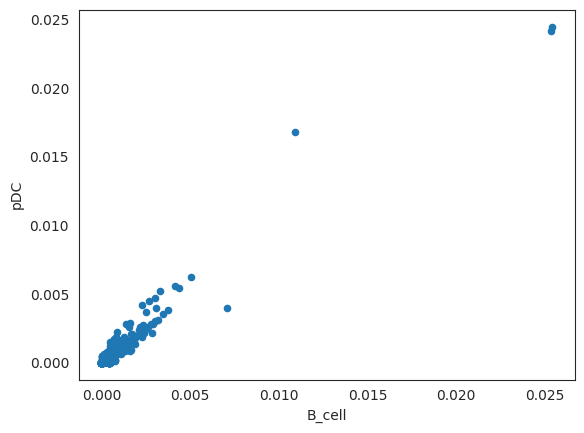

In [27]:
%matplotlib inline
total_effect.plot.scatter(x='B_cell', y='pDC')

<Axes: xlabel='B_cell', ylabel='Macrophage'>

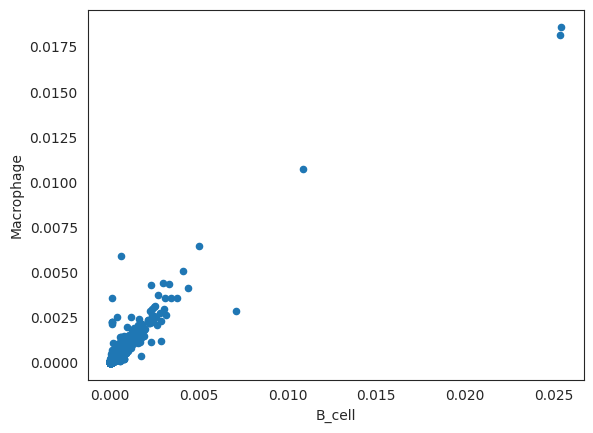

In [28]:
%matplotlib inline
total_effect.plot.scatter(x='B_cell', y='Macrophage')

<Axes: xlabel='pDC', ylabel='Macrophage'>

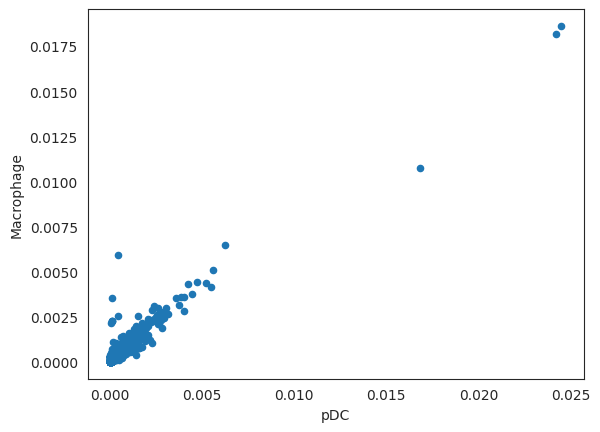

In [29]:
%matplotlib inline
total_effect.plot.scatter(x='pDC', y='Macrophage')

### Comparing the cell type effects of a perturbation

#### T cells CD4+ vs B cells responses to Cdc74

In [37]:
(total_effect["T_cell_CD4"] - total_effect["B_cell"]).sort_values(ascending=False)[:20]

gene
Icam1     0.002960
Il2ra     0.002371
Arl4a     0.002327
Il10      0.002318
Ell2      0.002197
Vegfa     0.000997
Hmox1     0.000991
Nfkb1     0.000886
Cxcr4     0.000822
Cdkn1a    0.000780
Il4       0.000757
Cxcr6     0.000694
Vim       0.000657
Ndrg1     0.000636
Nelfcd    0.000614
Cd40lg    0.000594
Thbs1     0.000593
Fos       0.000587
Ube2l6    0.000581
Eif4b     0.000567
dtype: float64

We can also plot the score of both cell types and highlight the genes with the highest difference. </br>
Here, we can notice notably Cd40lg, Cxcr4 and Cxcr6, known markers of T cell CD4+, overexpressed in these cells compared to B cells.

We can also plot the score of both cell types and highlight the genes with the highest difference.

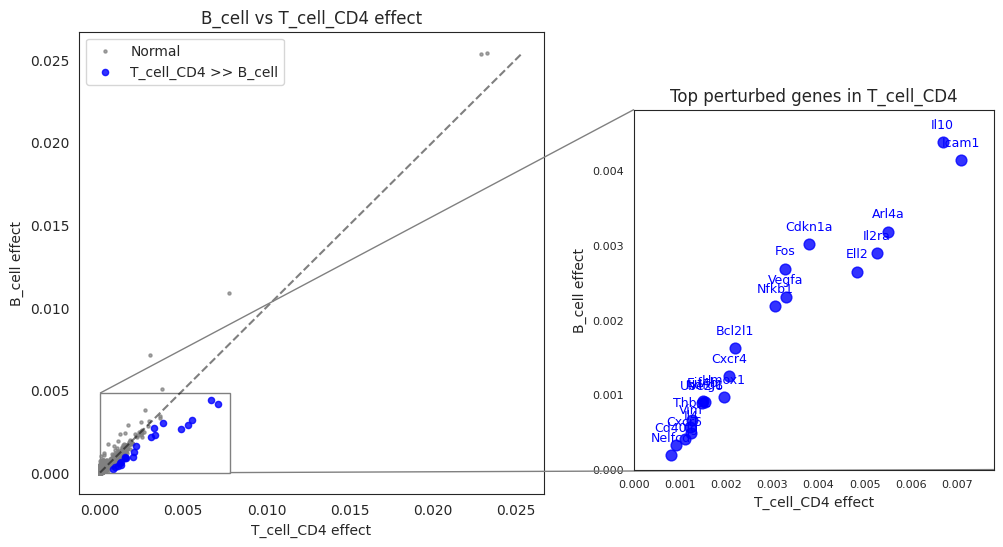

In [44]:
recon.plot.plot_celltype_comparison(total_effect, "T_cell_CD4", "B_cell", quantile=0.998)

### B cells over T cells

In [47]:
(total_effect["B_cell"] - total_effect["T_cell_CD4"]).sort_values(ascending=False)[:20]

gene
Cd86       0.004079
Ifng       0.003133
Ccnd1      0.002442
Myc        0.002150
Tnf        0.001323
Dusp4      0.001253
Sucla2     0.001190
Cd36       0.001136
Il1b       0.001095
Tdgf1      0.000992
Cd14       0.000957
Mmp9       0.000912
Itgal      0.000840
Ccl3       0.000785
Ccl5       0.000745
Tlr7       0.000692
Rhobtb2    0.000654
Ccr6       0.000603
Abcb1a     0.000591
Abcb1b     0.000591
dtype: float64

When checking the genes with the highest expression difference between B cells and CD4+ T cells, we notably find here Cd86 (marker of antigen presenting cells - including B cells), and Ccr6 (or ligand CCL20), an classical markers of B cells¹⁻²

_[1] Suan D, Kräutler NJ, Maag JLV, et al. CCR6 Defines Memory B Cell Precursors in Mouse and Human Germinal Centers, Revealing Light-Zone Location and Predominant Low Antigen Affinity. Immunity. 2017;47(6):1142-1153.e4. doi:10.1016/j.immuni.2017.11.022 </br>_

_[2]  Lee AYS, Körner H. The CCR6-CCL20 axis in humoral immunity and T-B cell immunobiology. Immunobiology. 2019;224(3):449-454. doi:10.1016/j.imbio.2019.01.005_

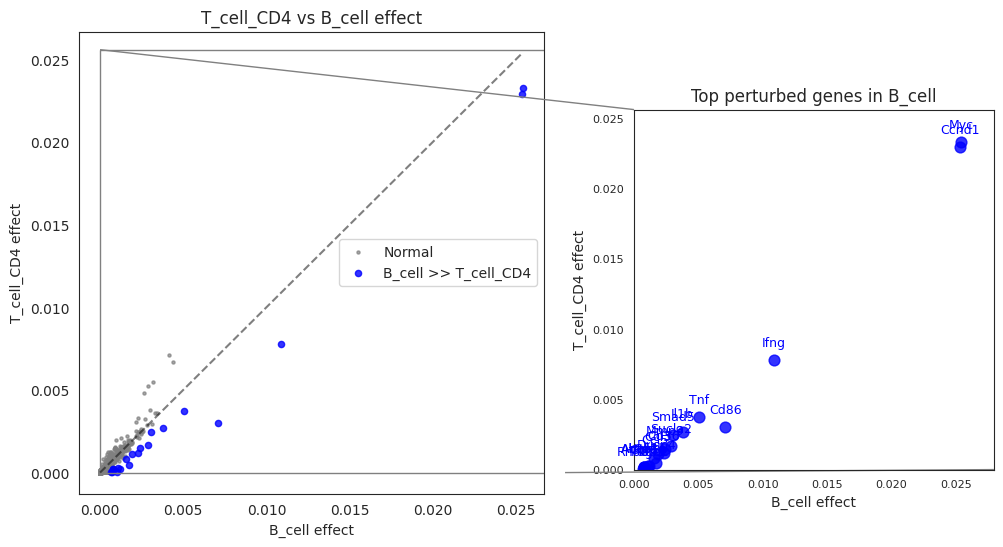

In [46]:
recon.plot.plot_celltype_comparison(total_effect, "B_cell", "T_cell_CD4", quantile=0.998)

### Macrophage versus others

In [62]:
(total_effect["Macrophage"] - total_effect.loc[:, ~total_effect.columns.isin(["Macrophage"])].mean(1)).sort_values(ascending=False)[:20]

gene
Ctnnb1    0.005161
Cr2       0.003296
Klrk1     0.002357
Klri1     0.002116
Klri2     0.002116
Klre1     0.002115
Klrd1     0.002041
Tnf       0.000945
Lcp2      0.000941
Vegfa     0.000828
Nfkbia    0.000771
Il2       0.000701
Cdkn1b    0.000687
Srebf1    0.000649
Mapk14    0.000610
Tgfb1     0.000571
Ifng      0.000563
Mmp9      0.000529
Rela      0.000524
Egr1      0.000503
dtype: float64

We notice here several known markers of macrophages, innate immunity and tissue remodelling, such as Tnf, Tgfb1, Mmp9

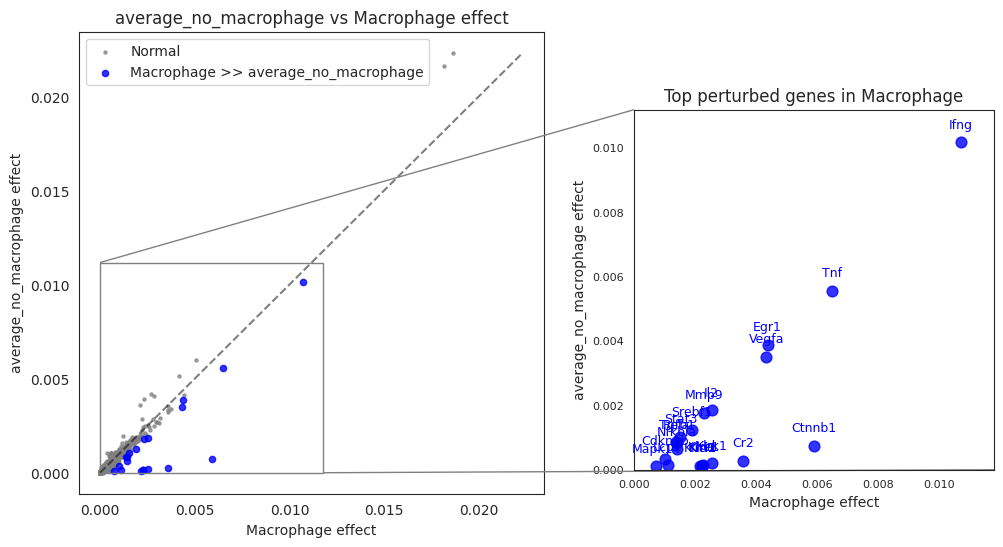

In [67]:
total_effect["average_no_macrophage"] = total_effect.loc[:, ~total_effect.columns.isin(["Macrophage"])].mean(axis=1)
recon.plot.plot_celltype_comparison(total_effect, "Macrophage", "average_no_macrophage", quantile=0.998)
# delete to not include it by mistake later
del total_effect["average_no_macrophage"]

## Gene rank across cell types

We can also compare the rank of each gene across the different cell types:

In [82]:
total_effect.rank().sort_values(by="NK_cell")[:10]

celltype_target,B_cell,pDC,Macrophage,NK_cell,T_cell_CD4,T_cell_CD8
gene,,,,,,
Ms4a4d,1.0,1.0,1.0,1.0,1.0,1.0
Hist1h2ac,2.0,2.0,2.0,2.0,2.0,2.0
Ifi27l2a,3.0,3.0,3.0,3.0,3.0,3.0
A3galt2,5.0,5.0,4.0,4.0,4.0,4.0
Tmem253,6.0,4.0,5.0,5.0,5.0,5.0
Hus1b,8.0,6.0,6.0,6.0,6.0,6.0
Kantr,9.0,7.0,7.0,7.0,7.0,8.0
Dazap2,19.0,12.0,11.0,8.0,12.0,7.0
Pcdhga10,4.0,31.0,18.0,9.0,11.0,9.0


There is often very few changes in-between the highest genes, that are often generic markers and metabolism related genes. </br>
It is usually more interesting to focus on genes of interest (here immune markers)

! Keep in mind for the interpretation that this is the prediction for one specific ligands.</br>

It is thus expected to not retrieve all markers since it does not represent the actual situation of your different cells.

In [105]:
markers = pd.Series([
    "Ptprc",   # pan-leukocyte (CD45)
    "Cd3e", "Trac",              # T cells
    "Cd4", "Cd8a",               # helper vs cytotoxic T
    "Ncr1", "Klrk1",             # NK cells
    "Ms4a1", "Cd19", "Cd79a",    # B cells
    "Sdc1",                      # plasmablasts/plasma cells
    "Lyz2", "Adgre1", "Csf1r",   # monocytes/macrophages
    "Itgax", "Zbtb46",           # conventional dendritic cells
    "Siglech",                   # plasmacytoid dendritic cells
    "Ly6g", "S100a8", "S100a9"   # neutrophils
])

markers = markers[markers.isin(total_effect.index).values]

total_effect.rank(ascending=False).loc[markers].sort_values(by="NK_cell")

celltype_target,B_cell,pDC,Macrophage,NK_cell,T_cell_CD4,T_cell_CD8
gene,,,,,,
Cd4,2738.0,856.0,750.0,549.0,2419.0,556.0
Csf1r,877.0,978.0,1038.0,573.0,578.0,558.0
S100a8,964.0,882.0,413.0,616.0,631.0,704.0
S100a9,1072.0,379.0,545.0,643.0,622.0,698.0
Cd19,724.0,1110.0,1378.0,670.0,678.0,694.0
Cd79a,583.0,1080.0,1013.0,836.0,838.0,986.0
Sdc1,1518.0,1170.0,1355.0,1031.0,986.0,1391.0
Itgax,1884.0,1856.0,2100.0,1359.0,1204.0,1363.0
Ptprc,1411.0,1362.0,1438.0,1418.0,2162.0,1692.0
